## Problem Statement/Overview
In this Kaggle competition, we use a set of small images showing microscopic tissue to train a model. This is therefore a classification problem: when the model sees future images of tissue, it should be trained in such a way that it can distinguish between tissues which present visual cues of metastatic cancer, and those which do not. Therefore, this is a binary problem.

In this specific dataset, we have over 277K images which are split between about 220K training images, with the rest being assigned to testing. There are no duplicate images in the dataset.

Images are provided in .tif format, while a .csv file lists the names of the images (an assortment of alphanumeric characters) and the value of their classification, either a 1 or 0. We look deeper at this in the EDA section. 

In [1]:
import numpy as np
import pandas as pd
import zipfile
import os
import matplotlib.pyplot as plt
import shutil
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import io
#from tensorflow.distribute import Strategy as strategy
print("TensorFlow version:", tf.__version__)
from tensorflow.keras import datasets, layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.io import imread 

TensorFlow version: 2.6.4


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

In [3]:
PATH = '/kaggle/input/histopathologic-cancer-detection/'

In [4]:
test_path = os.path.join(PATH, 'test/')
train_path = os.path.join(PATH, 'train/')
df_training = pd.read_csv(PATH+'train_labels.csv')

## Exploratory Data Analysis

First, let's take a look at the dataset using our .csv file of training images.

In [5]:
print(df_training.shape)
df_training.head()

(220025, 2)


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


We see our training set is 220,025 images, with an ID and a label. These labels indicate whether the training photo shows signes of metastatic cancer or not, with a 1 indicating a positive result. Let's see how our dataset is split.

In [6]:
print(df_training.label.value_counts())
zero, one = df_training.label.value_counts()
print(round((zero/len(df_training))*100,1),"% images marked 0.")
print(round((one/len(df_training))*100,1),"% images marked 1.")

0    130908
1     89117
Name: label, dtype: int64
59.5 % images marked 0.
40.5 % images marked 1.


<AxesSubplot:>

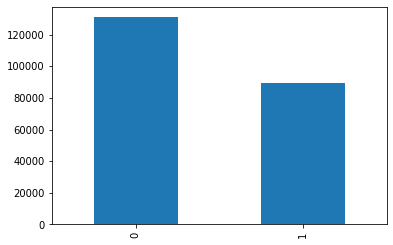

In [7]:
df_training.label.value_counts().plot(kind = 'bar')

Now that we've seen what our training data breakdown looks like, let's see what an actual image looks like!

In [8]:
## These methods were adapted from the following medium post: https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c

def edit_filename(string):
    return string+".tif"

df_training["id"] = df_training["id"].apply(edit_filename)
df_training['label'] = df_training['label'].astype(str)

df_training = shuffle(df_training, random_state=12)

print(df_training)

                                                  id label
216517  8b26151cf6c46429a021f305305a6c0f1c7040a5.tif     1
202518  3256bcf8abc0daf70bdf95eae1ff9ac07f3fc61f.tif     0
214160  7449033995d8ca6948796f1cf7aaba343bc42a82.tif     0
48520   1c9c5f2d9b6265acfcbd761a74dc1528b0335cc9.tif     1
156686  13d07c8da325607493f55e1cda77597578f820f2.tif     1
...                                              ...   ...
206083  22f474a69c129edeb8e2beede529643a1114f22f.tif     0
36482   b42c8adb32331a12e7153865bce61da0baabbf56.tif     1
40177   f426a587d42d51fe881249d21014d7329ca3ffd3.tif     1
150781  01b352f8703c28f742d52e42a95b89a6eb1c54f7.tif     0
210763  4f16cc7837f200162462d3bb717bb88a424ef8f1.tif     0

[220025 rows x 2 columns]


In [9]:
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.2)

In [10]:
with strategy.scope():
    training_generator = datagen.flow_from_dataframe(dataframe=df_training, directory=train_path, x_col="id", y_col="label", subset="training", batch_size=128, seed=12, class_mode="binary", target_size=(64,64))

Found 176020 validated image filenames belonging to 2 classes.


In [11]:
with strategy.scope():
    validation_generator = datagen.flow_from_dataframe(dataframe=df_training, directory=train_path, x_col="id", y_col="label", subset="validation", batch_size=128, seed=12, class_mode="binary", target_size=(64,64))  

Found 44005 validated image filenames belonging to 2 classes.


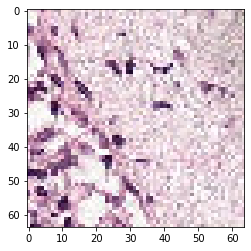

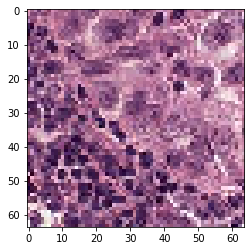

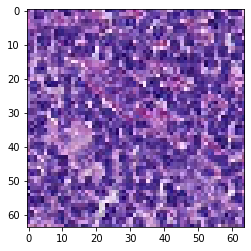

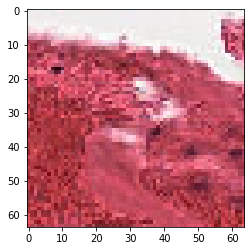

In [12]:
sample_img = next(iter(training_generator))
for i in range(0, 4):
    plt.imshow(sample_img[0][i])
    plt.show()

## Model Architecture
Due to the nature of the assignment, I have chosen to use a Convolutional Neural Network (CNN) to classify our test images. Convolution is a useful tactic in dealing with images because, simply put, images have a lot of data (pixel height times pixel length times dimensions, oftentimes three). Because of this, a densely connected network will tend to run slow, and importantly, to overfit. Convolution networks try to overcome these shortcomings.

Below, I try out two models. Both are relatively simple, with the first model being more rudimentary.

In [13]:
with strategy.scope():
    model = models.Sequential()
    model.add(layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
    model.add(layers.AveragePooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
  #  model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.AveragePooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model.add(layers.AveragePooling2D(pool_size=(2,2)))
  #  model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
 #   model.add(layers.AveragePooling2D(pool_size=(2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='sigmoid'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.build(input_shape=(256, 64, 64, 3)) 

2022-10-22 23:33:25.821498: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-22 23:33:25.917337: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-22 23:33:25.918190: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-22 23:33:25.919792: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

This first model uses several types of layers. There are four layers that are traditional 2-dimensional convolution layers, which have 16 layers apiece before the pooling layer and 32 filters after the pooling layer. THe kernel size across the board is 3x3, which is the height and width of the convolution window. The activation function specified here is 'relu', although other functions such as 'sigmoid' could also be applied. 

The pooling layer is used to reduce the data by taking the average value in a given window. Here, we use a pool size of 2x2 in order to effectively sub-sample the input data. 

In the end, we flatten the data using a flatten layer in order to feed the network into a dense layer, which we can append to the end of a CNN. In this case, we use a sigmoid activation function and we specify that the output should be 1, which is to say, a single dimension.

Finally, in this first model, we are going to use a batch size of 256, which is relatively large, in order to loop through our data quickly to get a sense of starting values.

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (256, 62, 62, 16)         448       
_________________________________________________________________
average_pooling2d (AveragePo (256, 31, 31, 16)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (256, 29, 29, 16)         2320      
_________________________________________________________________
average_pooling2d_1 (Average (256, 14, 14, 16)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (256, 12, 12, 32)         4640      
_________________________________________________________________
average_pooling2d_2 (Average (256, 6, 6, 32)           0         
_________________________________________________________________
flatten (Flatten)            (256, 1152)               0

In [15]:
with strategy.scope():
    model.compile(loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()], optimizer = optimizers.Adam(learning_rate=0.001))

In [16]:
#with strategy.scope():
history = model.fit_generator(training_generator, epochs=60, validation_data = validation_generator)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-10-22 23:33:28.927295: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60


2022-10-22 23:33:31.901625: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1376/1376 [==============================] - 1675s 1s/step - loss: 0.4821 - accuracy: 0.7763 - auc: 0.8425 - val_loss: 0.4463 - val_accuracy: 0.7993 - val_auc: 0.8693
Epoch 2/60
1376/1376 [==============================] - 309s 224ms/step - loss: 0.4335 - accuracy: 0.8062 - auc: 0.8746 - val_loss: 0.4023 - val_accuracy: 0.8223 - val_auc: 0.8940
Epoch 3/60
1376/1376 [==============================] - 314s 229ms/step - loss: 0.4025 - accuracy: 0.8237 - auc: 0.8929 - val_loss: 0.4541 - val_accuracy: 0.7951 - val_auc: 0.8831
Epoch 4/60
1376/1376 [==============================] - 303s 220ms/step - loss: 0.3846 - accuracy: 0.8337 - auc: 0.9030 - val_loss: 0.3939 - val_accuracy: 0.8271 - val_auc: 0.9055
Epoch 5/60
1376/1376 [==============================] - 292s 212ms/step - loss: 0.3698 - accuracy: 0.8400 - auc: 0.9108 - val_loss: 0.3544 - val_accuracy: 0.8484 - val_auc: 0.9194
Epoch 6/60
1376/1376 [==============================] - 290s 211ms/step - loss: 0.3597 - accuracy: 0.8462 - auc: 

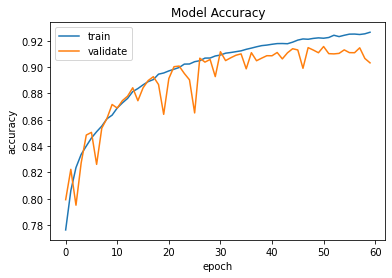

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'])
plt.show()

Okay, after that first model, we're going to try a second model that has far more parameters, but try to also keep it somewhat reasonable given resource constraints.

Similar to the first model, we're going to have convolutional layers followed by pooling layers. Here, we're going to pair convolutional layers followed by a max pooling layer, a batch normalization layer, and a dropout layer. Both of these last two layer types can help with regularization, as we learned in lecture. We are going to have three sets of these layer types.

We will finish with an extra dense layer, again with a dropout layer to keep our parameter number under control. Finally, at the compile step, I'm using the Nadam optimizer and specifying the learning rate at 0.0001. Again, we're going to run for 60 epochs (since a previous version of a similar model did not converge over 40 epochs). 

Here we go!

In [18]:
with strategy.scope():
    training_generator = datagen.flow_from_dataframe(dataframe=df_training, directory=train_path, x_col="id", y_col="label", subset="training", batch_size=256, seed=12, class_mode="binary", target_size=(64,64))

Found 176020 validated image filenames belonging to 2 classes.


In [19]:
with strategy.scope():
    validation_generator = datagen.flow_from_dataframe(dataframe=df_training, directory=train_path, x_col="id", y_col="label", subset="validation", batch_size=256, seed=12, class_mode="binary", target_size=(64,64))  

Found 44005 validated image filenames belonging to 2 classes.


In [20]:
with strategy.scope():
    model_v2 = models.Sequential()
    model_v2.add(layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
    model_v2.add(layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
    model_v2.add(layers.MaxPooling2D(pool_size=(2,2)))
    model_v2.add(layers.BatchNormalization())
    model_v2.add(layers.Dropout(0.25))
    
    model_v2.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model_v2.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model_v2.add(layers.MaxPooling2D(pool_size=(2,2)))
    model_v2.add(layers.BatchNormalization())
    model_v2.add(layers.Dropout(0.25))
    
    model_v2.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model_v2.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model_v2.add(layers.MaxPooling2D(pool_size=(2,2)))
    model_v2.add(layers.BatchNormalization())
    model_v2.add(layers.Dropout(0.25))
    
    model_v2.add(layers.Flatten())
    model_v2.add(layers.Dense(10, activation='sigmoid'))
    model_v2.add(layers.Dropout(0.25))
    model_v2.add(layers.Dense(1, activation='sigmoid'))
    model_v2.build(input_shape=(256, 64, 64, 3)) 

In [21]:
model_v2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (256, 62, 62, 16)         448       
_________________________________________________________________
conv2d_4 (Conv2D)            (256, 60, 60, 16)         2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (256, 30, 30, 16)         0         
_________________________________________________________________
batch_normalization (BatchNo (256, 30, 30, 16)         64        
_________________________________________________________________
dropout (Dropout)            (256, 30, 30, 16)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (256, 28, 28, 32)         4640      
_________________________________________________________________
conv2d_6 (Conv2D)            (256, 26, 26, 32)        

In [22]:
with strategy.scope():
    model_v2.compile(loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()], optimizer = optimizers.Nadam(learning_rate=0.0001))

In [23]:
with strategy.scope():
    history_v2 = model_v2.fit_generator(training_generator, epochs=60, validation_data = validation_generator)

Epoch 1/60
688/688 [==============================] - 317s 458ms/step - loss: 0.4964 - accuracy: 0.7793 - auc_1: 0.8362 - val_loss: 0.4852 - val_accuracy: 0.7760 - val_auc_1: 0.8517
Epoch 2/60
688/688 [==============================] - 311s 452ms/step - loss: 0.4364 - accuracy: 0.8188 - auc_1: 0.8758 - val_loss: 0.4464 - val_accuracy: 0.8118 - val_auc_1: 0.8884
Epoch 3/60
688/688 [==============================] - 306s 445ms/step - loss: 0.4100 - accuracy: 0.8330 - auc_1: 0.8906 - val_loss: 0.4334 - val_accuracy: 0.8180 - val_auc_1: 0.8905
Epoch 4/60
688/688 [==============================] - 315s 458ms/step - loss: 0.3903 - accuracy: 0.8422 - auc_1: 0.9012 - val_loss: 0.3979 - val_accuracy: 0.8325 - val_auc_1: 0.9070
Epoch 5/60
688/688 [==============================] - 303s 441ms/step - loss: 0.3769 - accuracy: 0.8481 - auc_1: 0.9080 - val_loss: 0.3973 - val_accuracy: 0.8287 - val_auc_1: 0.9123
Epoch 6/60
688/688 [==============================] - 300s 435ms/step - loss: 0.3634 - acc

## Results and Analysis

Let's plot our results from this second model.

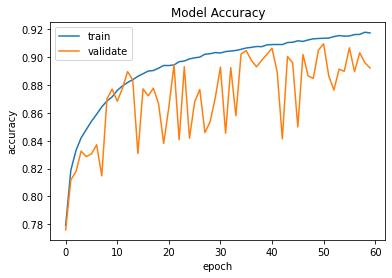

In [24]:
plt.plot(history_v2.history['accuracy'])
plt.plot(history_v2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'])
plt.show()

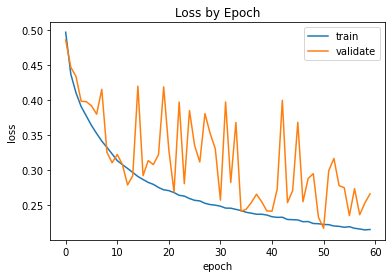

In [25]:
plt.plot(history_v2.history['loss'])
plt.plot(history_v2.history['val_loss'])
plt.title('Loss by Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'])
plt.show()

Above, we can see that our more expensive model doesn't actually perform that much better, converges at about the same rate, and the validation accuracy is much more sporatic than our baseline model.

Is this second model better than the first? In some ways, it appears that some of our "extra" parameters are not as helpful as they may appear. Even though the training accuracy curves appear similar in both of these models, the validation accuracy curve (and therefore the validation loss curve) for the second has much more variation involved, meaning that we are likely overfitting with this model. Regardless, we will use this model to score on the Kaggle leaderboard.

Now that we've trained our two models, let's generate the data for our testing images and build a submission document based on this data. You will find the results of this submission in part III of this assignment submission within Coursera.

In [26]:
test_images = pd.DataFrame({'id':os.listdir(test_path)})
testing_datagen = ImageDataGenerator(rescale=1./255.)
testing_generator = testing_datagen.flow_from_dataframe(dataframe=test_images, directory=test_path, x_col='id', y_col=None, target_size=(64,64) ,batch_size=1, shuffle=False, class_mode=None)

Found 57458 validated image filenames.


In [27]:
predict = model_v2.predict(testing_generator, verbose=1)

57458/57458 [==============================] - 484s 8ms/step


In [28]:
submit = pd.DataFrame()
submit['id'] = test_images['id'].apply(lambda x: x.split('.')[0])
submit['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predict))
submit.head()
submit.to_csv('cnn_submit.csv', index=False)

## Conclusion
After working with CNNs and trying multiple options, it's easy to feel like your head is spinning. Between selecting layer types, hyperparameters within each layer, activation and optimization techniques, there are a lot of factors to consider.

In addition to this, given the vast computing resources available now, it can be easy to add far more layers and utilize many more techniques than are necessary. 

My largest takeaway is related to this: with all of the factors that one can control when creating a model and because you can maximize your accuracy to the training (and even to the validation) set to an incredible degree, it is easy to have a lot of confidence that your model is very accurate and strong. However, I think it's important, especially when dealing with medical imaging and potentially very impactful and life-altering data such as this, to keep in mind that no model is flawless, and design should be taken very seriously. While most of the work above was the result of trial and error, reading blogs, and referencing documentation, seeking guidance from qualified experts is an important step in using deep learning.